In [1]:
import sys
import os
import pystac_client
from dotenv import load_dotenv

import requests
import pandas as pd
from datetime import datetime, timedelta
import os
from loguru import logger
import time
import rasterio
import os
import io
import cv2
import numpy as np
from PIL import Image

from dotenv import load_dotenv
notebook_dir = os.path.abspath('')
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

# Now import the module
from src.auth.auth import S3Connector
from src.utils.utils import remove_last_segment_rsplit
from src.utils.cdse_utils import (create_cdse_query_url, download_bands)

In [2]:
from dotenv import load_dotenv
notebook_dir = os.path.abspath('')
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

# Now import the module
from src.auth.auth import S3Connector
from src.utils.utils import extract_s3_path_from_url


load_dotenv()
ACCESS_KEY_ID = os.environ.get("ACCESS_KEY_ID")
SECRET_ACCESS_KEY = os.environ.get("SECRET_ACCESS_KEY")
ENDPOINT_URL = 'https://eodata.dataspace.copernicus.eu'
ENDPOINT_STAC = "https://stac.dataspace.copernicus.eu/v1/"
DATASET_VERSION = "V3"
BUCKET_NAME = "eodata"
BASE_DIR = f"/mnt/disk/dataset/sentinel-ai-processor"
DATASET_DIR = f"{BASE_DIR}/{DATASET_VERSION}"
BANDS = ['TCI']
catalog = pystac_client.Client.open(ENDPOINT_STAC)

connector = S3Connector(
    endpoint_url=ENDPOINT_URL,
    access_key_id=ACCESS_KEY_ID,
    secret_access_key=SECRET_ACCESS_KEY,
    region_name='default'
)
# Get S3 client and resource from the connector instance
s3 = connector.get_s3_resource()
s3_client = connector.get_s3_client()
buckets = connector.list_buckets()
bucket = s3.Bucket(BUCKET_NAME)

input_dir = os.path.join(DATASET_DIR, "input")
output_dir = os.path.join(DATASET_DIR, "output")
os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

In [3]:
def get_product_content(s3_client, bucket_name, object_url):
    """
    Download the content of a product from S3 bucket.

    Args:
        s3_client: boto3 S3 client object
        bucket_name (str): Name of the S3 bucket
        object_url (str): Path to the object within the bucket

    Returns:
        bytes: Content of the downloaded file
    """
    print(f"Downloading {object_url}")

    try:
        # Download the file from S3
        response = s3_client.get_object(Bucket=bucket_name, Key=object_url)
        content = response['Body'].read()
        print(f"Successfully downloaded {object_url}")
    except Exception as e:
        print(f"Error downloading file: {str(e)}")
        raise

    return content

## Search for a product on STAC

In [4]:
# Define bounding box coordinates [min_lon, min_lat, max_lon, max_lat]
min_lon, min_lat, max_lon, max_lat = 150.95,-20.92, 150.97, -20.95  # Example: 1° box around LON=15, LAT=50

# Create a bounding box polygon (must be closed, so repeat the first point at the end)
bbox_polygon = {
    "type": "Polygon",
    "coordinates": [[
        [min_lon, min_lat],  # Southwest corner
        [max_lon, min_lat],  # Southeast corner
        [max_lon, max_lat],  # Northeast corner
        [min_lon, max_lat],  # Northwest corner
        [min_lon, min_lat]   # Close the polygon by repeating the first point
    ]]
}

# Search for Sentinel-2 products within the bounding box
items_txt = catalog.search(
    collections=['sentinel-2-l2a'],
    intersects=bbox_polygon,
    datetime="2024-05-01/2024-06-01",
    query=["eo:cloud_cover<50"]
).item_collection()

In [5]:
selected_item = items_txt[0]
product_url = selected_item.assets['TCI_60m'].href
product_url = extract_s3_path_from_url(selected_item.assets['TCI_60m'].href)
product_content = get_product_content(s3_client=s3_client, bucket_name="eodata",
                                     object_url=product_url)

Successfully downloaded Sentinel-2/MSI/L2A/2024/05/26/S2B_MSIL2A_20240526T001109_N0510_R073_T56KKB_20240526T013407.SAFE/GRANULE/L2A_T56KKB_A037708_20240526T001110/IMG_DATA/R60m/T56KKB_20240526T001109_TCI_60m.jp2


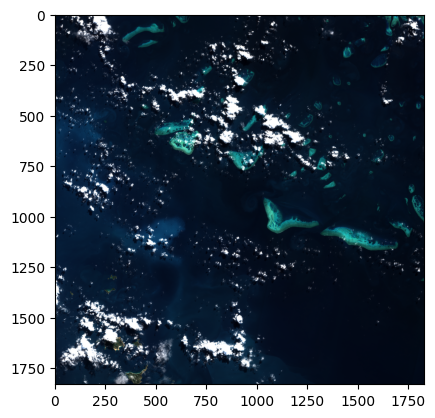

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
image = Image.open(io.BytesIO(product_content))
plt.imshow(image)
plt.savefig('test.png',dpi=200,bbox_inches='tight')

In [9]:
product_url_b02 = extract_s3_path_from_url(selected_item.assets['B02_60m'].href)
product_url_b03 = extract_s3_path_from_url(selected_item.assets['B03_60m'].href)
product_url_b04 = extract_s3_path_from_url(selected_item.assets['B04_60m'].href)

product_paths = [product_url_b02,product_url_b03 ,product_url_b04]



product = get_product_content(s3_client=s3_client, bucket_name="eodata",
                                    object_url=product_paths[0])
blue = np.array(Image.open(io.BytesIO(product)))

product = get_product_content(s3_client=s3_client, bucket_name="eodata",
                                    object_url=product_paths[1])
red = np.array(Image.open(io.BytesIO(product)))


product = get_product_content(s3_client=s3_client, bucket_name="eodata",
                                    object_url=product_paths[2])
green = np.array(Image.open(io.BytesIO(product)))

Successfully downloaded Sentinel-2/MSI/L2A/2024/05/26/S2B_MSIL2A_20240526T001109_N0510_R073_T56KKB_20240526T013407.SAFE/GRANULE/L2A_T56KKB_A037708_20240526T001110/IMG_DATA/R60m/T56KKB_20240526T001109_B02_60m.jp2
Successfully downloaded Sentinel-2/MSI/L2A/2024/05/26/S2B_MSIL2A_20240526T001109_N0510_R073_T56KKB_20240526T013407.SAFE/GRANULE/L2A_T56KKB_A037708_20240526T001110/IMG_DATA/R60m/T56KKB_20240526T001109_B03_60m.jp2
Successfully downloaded Sentinel-2/MSI/L2A/2024/05/26/S2B_MSIL2A_20240526T001109_N0510_R073_T56KKB_20240526T013407.SAFE/GRANULE/L2A_T56KKB_A037708_20240526T001110/IMG_DATA/R60m/T56KKB_20240526T001109_B04_60m.jp2


In [11]:
blue = np.array(Image.open(io.BytesIO(product)))

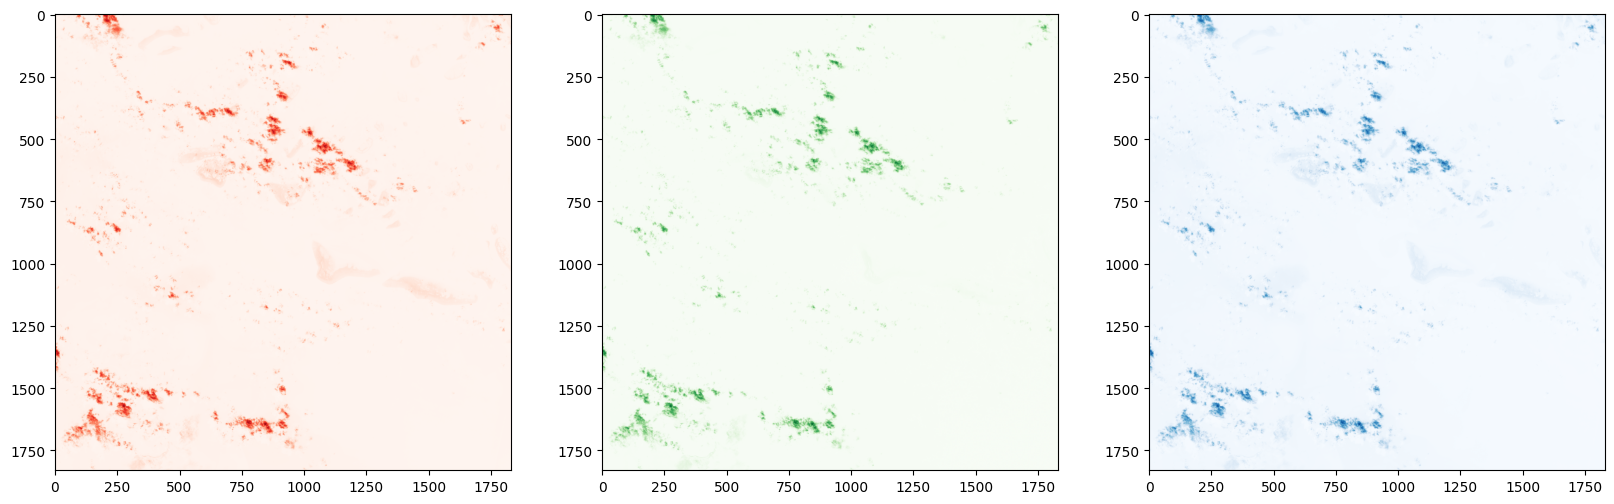

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(red, cmap='Reds')
ax1 = fig.add_subplot(1,3,2)
ax1.imshow(green, cmap='Greens')
ax1 = fig.add_subplot(1,3,3)
ax1.imshow(blue, cmap='Blues')

In [30]:
rgb_composite_raw= np.dstack((red, green, blue))
rgb_composite_raw.shape

(1830, 1830, 3)

In [31]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

red_n = normalize(red)
green_n = normalize(green)
blue_n = normalize(blue)

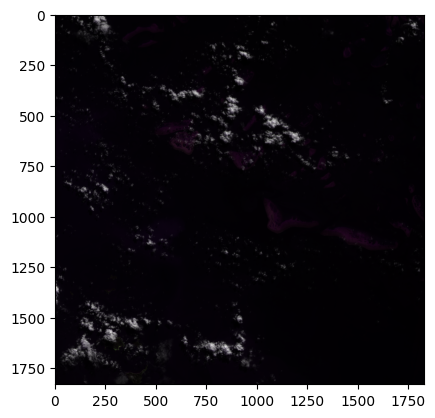

In [32]:
rgb_composite_n= np.dstack((red_n, green_n, blue_n))
plt.imshow(rgb_composite_n)
plt.savefig('test.png',dpi=200,bbox_inches='tight')

Successfully downloaded Sentinel-2/MSI/L2A/2024/05/26/S2B_MSIL2A_20240526T001109_N0510_R073_T56KKB_20240526T013407.SAFE/GRANULE/L2A_T56KKB_A037708_20240526T001110/IMG_DATA/R10m/T56KKB_20240526T001109_B04_10m.jp2


/home/ubuntu/miniconda3/envs/ai_processor/lib/python3.12/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (120560400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Successfully downloaded Sentinel-2/MSI/L2A/2024/05/26/S2B_MSIL2A_20240526T001109_N0510_R073_T56KKB_20240526T013407.SAFE/GRANULE/L2A_T56KKB_A037708_20240526T001110/IMG_DATA/R10m/T56KKB_20240526T001109_B03_10m.jp2
Successfully downloaded Sentinel-2/MSI/L2A/2024/05/26/S2B_MSIL2A_20240526T001109_N0510_R073_T56KKB_20240526T013407.SAFE/GRANULE/L2A_T56KKB_A037708_20240526T001110/IMG_DATA/R10m/T56KKB_20240526T001109_B02_10m.jp2


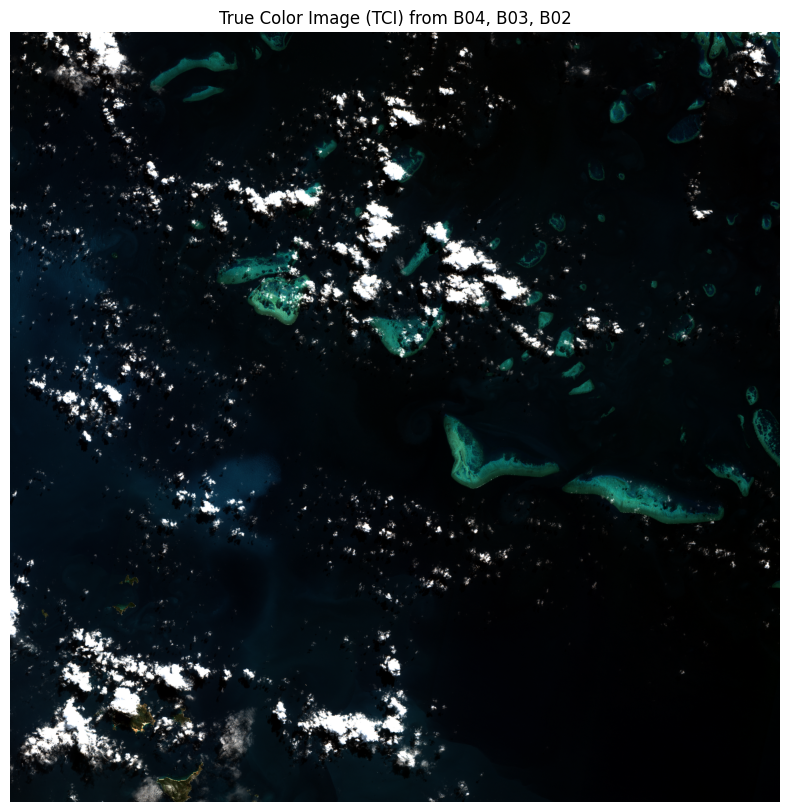

In [35]:
import numpy as np
from PIL import Image
import io
import matplotlib.pyplot as plt
import cv2
# Download bands from S3 and convert to arrays
product = get_product_content(s3_client=s3_client, bucket_name="eodata", object_url=product_paths[2])
red = np.array(Image.open(io.BytesIO(product)), dtype=np.float32)
red = cv2.resize(red, (1830,1830) , interpolation=cv2.INTER_CUBIC)

product = get_product_content(s3_client=s3_client, bucket_name="eodata", object_url=product_paths[1])
green = np.array(Image.open(io.BytesIO(product)), dtype=np.float32)
green = cv2.resize(green, (1830,1830) , interpolation=cv2.INTER_CUBIC)
product = get_product_content(s3_client=s3_client, bucket_name="eodata", object_url=product_paths[0])
blue = np.array(Image.open(io.BytesIO(product)), dtype=np.float32)
blue = cv2.resize(blue, (1830,1830) , interpolation=cv2.INTER_CUBIC)

# Optional: Rescale to 0-1
def normalize(band, lower_percent=2, upper_percent=98):
    """Apply percentile stretching to enhance contrast."""
    lower = np.percentile(band, lower_percent)
    upper = np.percentile(band, upper_percent)
    stretched = np.clip((band - lower) / (upper - lower), 0, 1)
    return stretched

# Normalize each band
red_norm = normalize(red)
green_norm = normalize(green)
blue_norm = normalize(blue)

# Stack into RGB image
rgb = np.dstack((red_norm, green_norm, blue_norm))

# Display
plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.title("True Color Image (TCI) from B04, B03, B02")
plt.axis('off')
plt.show()
